In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression,Ridge
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [2]:
weather_data = pd.read_csv("../b Datasets/Temperature Trends/TemperatureTrends.csv")
weather_data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.


In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96231 entries, 0 to 96230
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Formatted Date          93203 non-null  object 
 1   Summary                 96231 non-null  object 
 2   Precip Type             95714 non-null  object 
 3   Temperature (C)         96231 non-null  float64
 4   Humidity                96231 non-null  float64
 5   Wind Speed (km/h)       96231 non-null  float64
 6   Wind Bearing (degrees)  96231 non-null  int64  
 7   Visibility (km)         96231 non-null  float64
 8   Loud Cover              96231 non-null  int64  
 9   Pressure (millibars)    96231 non-null  float64
 10  Daily Summary           96231 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 8.1+ MB


In [4]:
weather_data.select_dtypes(include="number").std()

Temperature (C)             9.494446
Humidity                    0.194187
Wind Speed (km/h)           6.910747
Wind Bearing (degrees)    107.398623
Visibility (km)             4.191105
Loud Cover                  0.000000
Pressure (millibars)      117.056270
dtype: float64

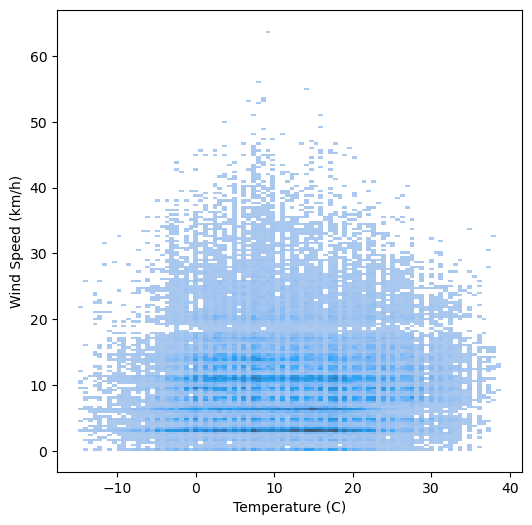

In [5]:
plt.figure(figsize=(6,6))
sns.histplot(data=weather_data, y="Wind Speed (km/h)", x="Temperature (C)")
plt.show()

In [6]:
weather_data.isna().sum()

Formatted Date            3028
Summary                      0
Precip Type                517
Temperature (C)              0
Humidity                     0
Wind Speed (km/h)            0
Wind Bearing (degrees)       0
Visibility (km)              0
Loud Cover                   0
Pressure (millibars)         0
Daily Summary                0
dtype: int64

In [7]:
weather_data.isna().sum() / len(weather_data) * 100

Formatted Date            3.146595
Summary                   0.000000
Precip Type               0.537249
Temperature (C)           0.000000
Humidity                  0.000000
Wind Speed (km/h)         0.000000
Wind Bearing (degrees)    0.000000
Visibility (km)           0.000000
Loud Cover                0.000000
Pressure (millibars)      0.000000
Daily Summary             0.000000
dtype: float64

In [8]:
weather_data.dropna(inplace=True)
weather_data.isna().sum()

Formatted Date            0
Summary                   0
Precip Type               0
Temperature (C)           0
Humidity                  0
Wind Speed (km/h)         0
Wind Bearing (degrees)    0
Visibility (km)           0
Loud Cover                0
Pressure (millibars)      0
Daily Summary             0
dtype: int64

In [9]:
weather_data["Formatted Date"] = pd.to_datetime(weather_data["Formatted Date"])
weather_data["year"] = weather_data["Formatted Date"].dt.year
weather_data["month"] = weather_data["Formatted Date"].dt.month
weather_data["day"] = weather_data["Formatted Date"].dt.day
weather_data["hour"] = weather_data["Formatted Date"].dt.hour
weather_data

,Formatted Date,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,year,month,day,hour
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.,2006,3,31,22
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.,2006,3,31,23
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.,2006,4,1,0
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.,2006,4,1,1
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.,2006,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93198,2016-09-09 17:00:00+00:00,Overcast,rain,11.244444,0.63,15.4238,164,15.5526,0,1006.80,Mostly cloudy starting overnight.,2016,9,9,17
93199,2016-09-09 18:00:00+00:00,Overcast,rain,10.000000,0.71,12.6868,160,16.1000,0,1006.61,Mostly cloudy starting overnight.,2016,9,9,18
93200,2016-09-09 19:00:00+00:00,Mostly Cloudy,rain,8.794444,0.72,12.4131,150,16.1000,0,1006.43,Mostly cloudy starting overnight.,2016,9,9,19
93201,2016-09-09 20:00:00+00:00,Mostly Cloudy,rain,7.783333,0.77,13.8621,141,14.9569,0,1006.13,Mostly cloudy starting overnight.,2016,9,9,20


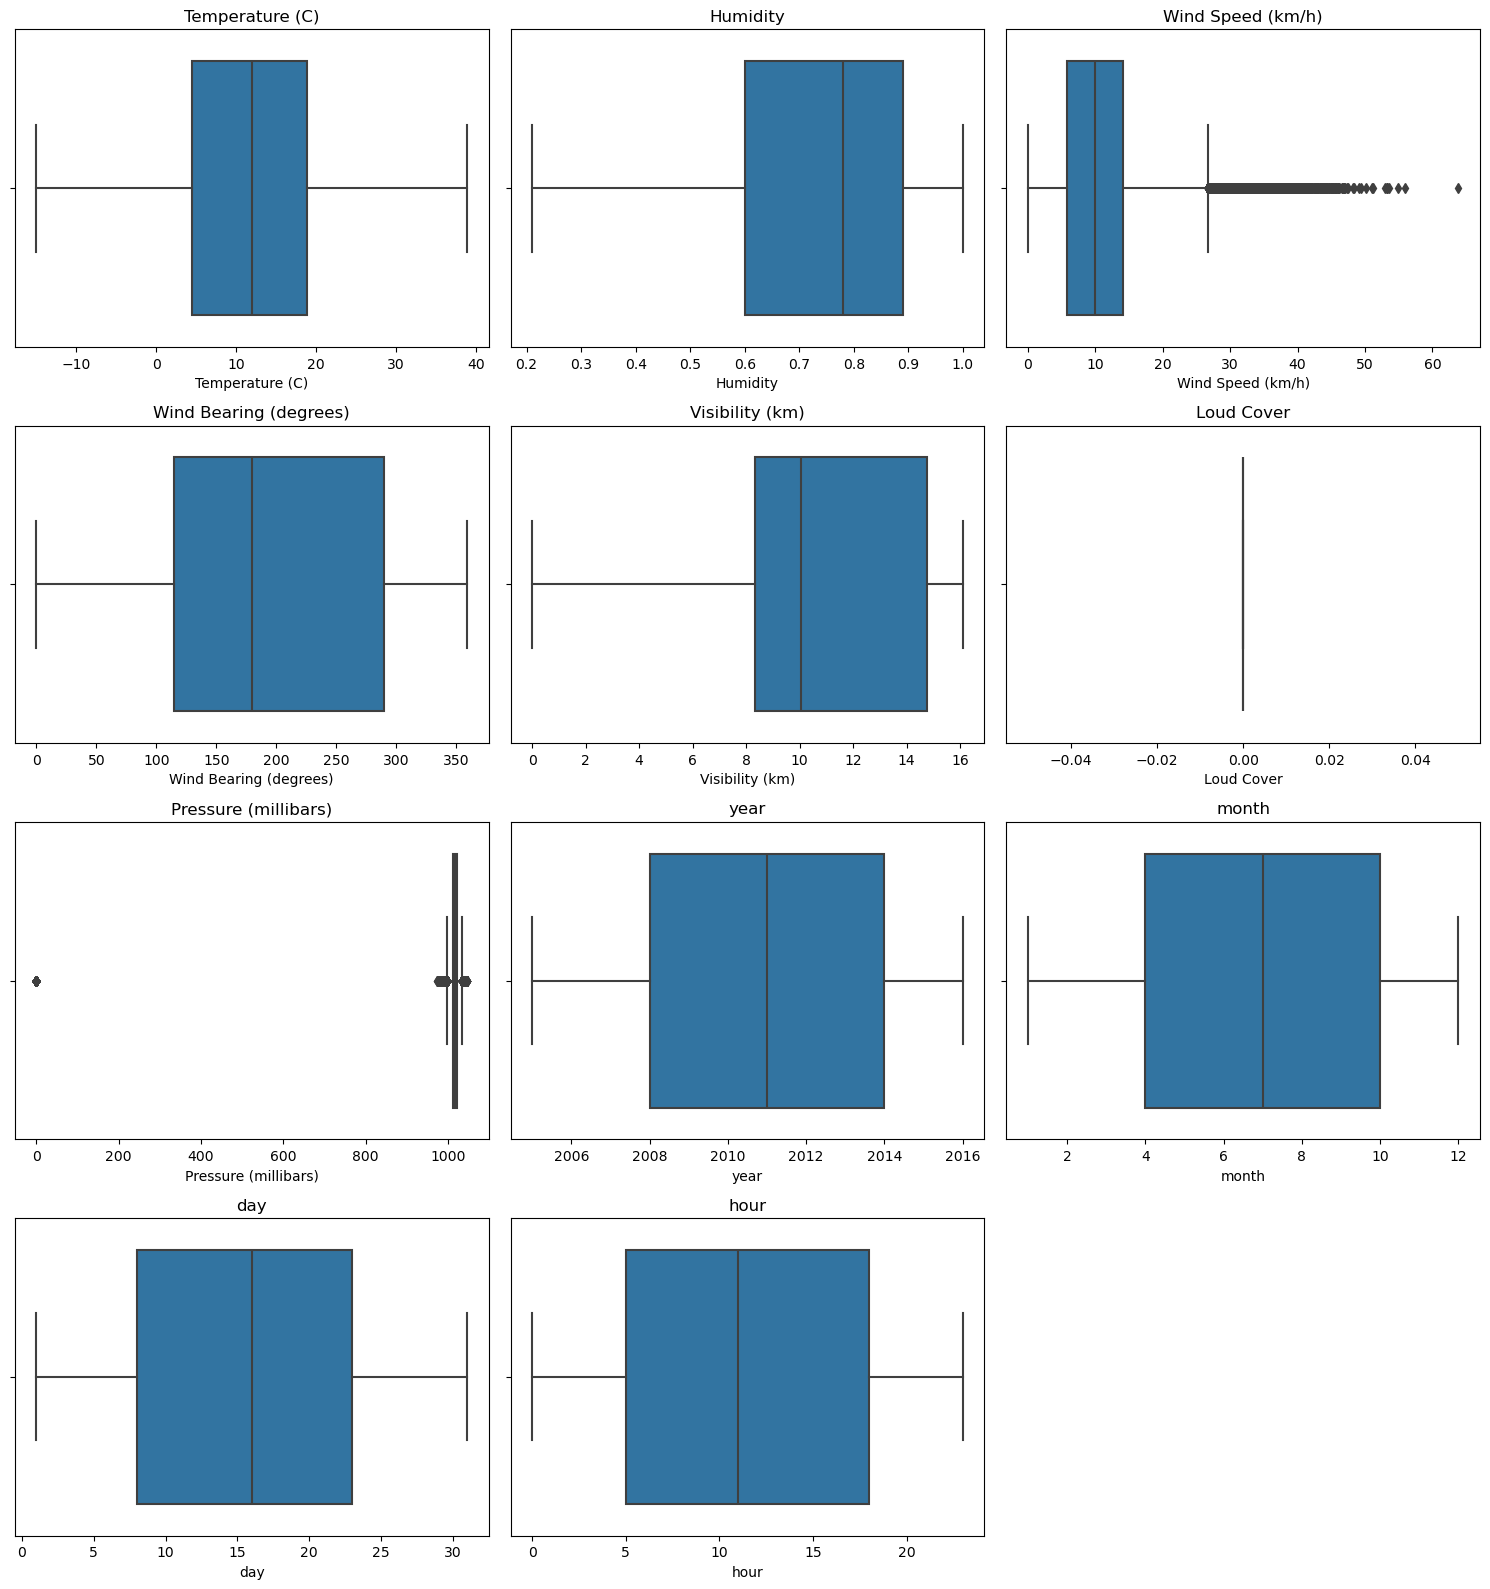

In [10]:
numerical_features = weather_data.select_dtypes(include='number')
num_cols = 3
num_rows = (len(numerical_features.columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_features.columns):
    sns.boxplot(data=weather_data, x=col, ax=axes[idx])
    axes[idx].set_title(col)

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
numerical_weather_data = weather_data.select_dtypes(include="number")
Q1 = numerical_weather_data.quantile(0.25)
Q3 = numerical_weather_data.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR
weather_data = weather_data[~ ((numerical_weather_data > upper_bound) | (numerical_weather_data < lower_bound)).any(axis=1)]

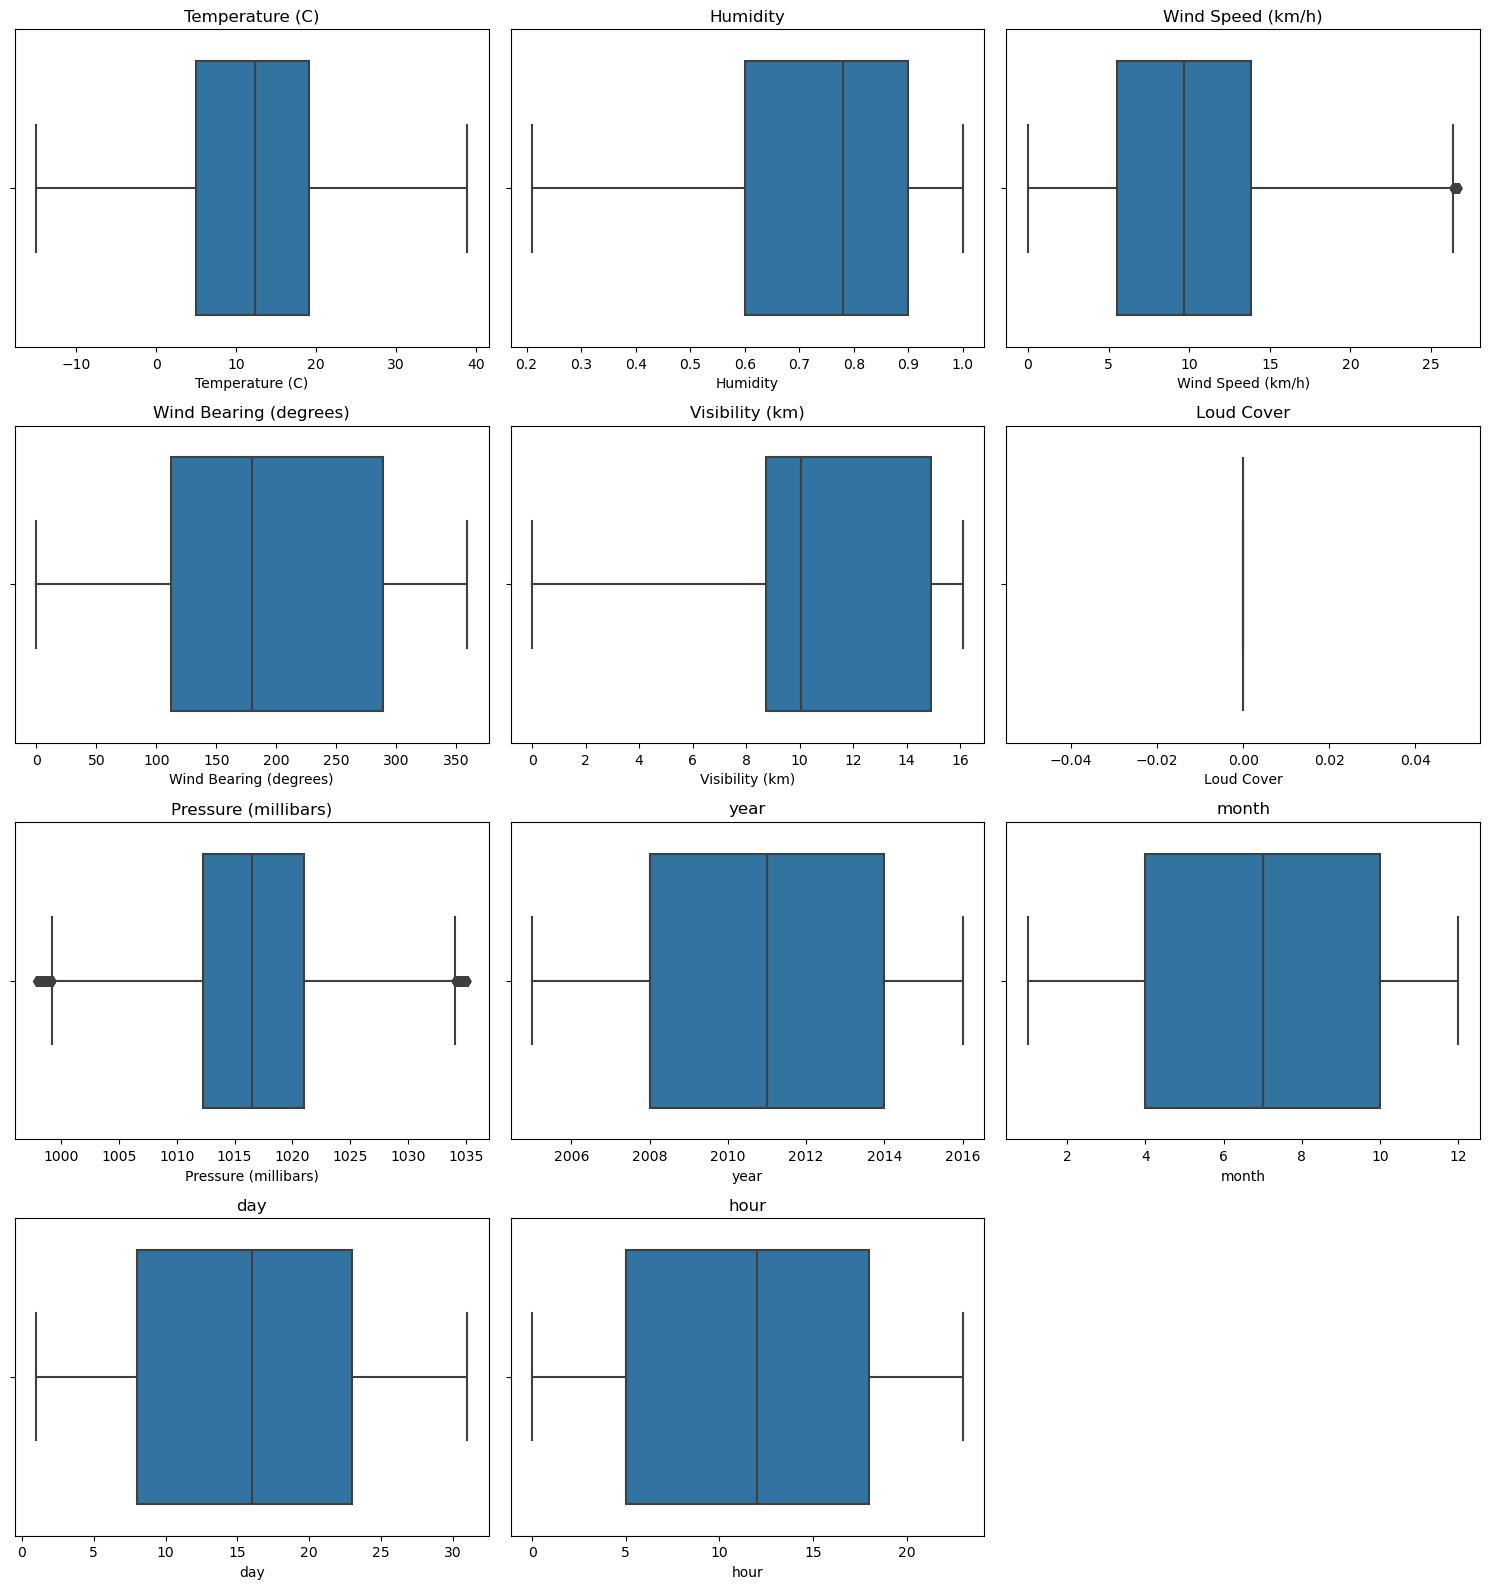

In [12]:
numerical_features = weather_data.select_dtypes(include='number')
num_cols = 3
num_rows = (len(numerical_features.columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_features.columns):
    sns.boxplot(data=weather_data, x=col, ax=axes[idx])
    axes[idx].set_title(col)

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

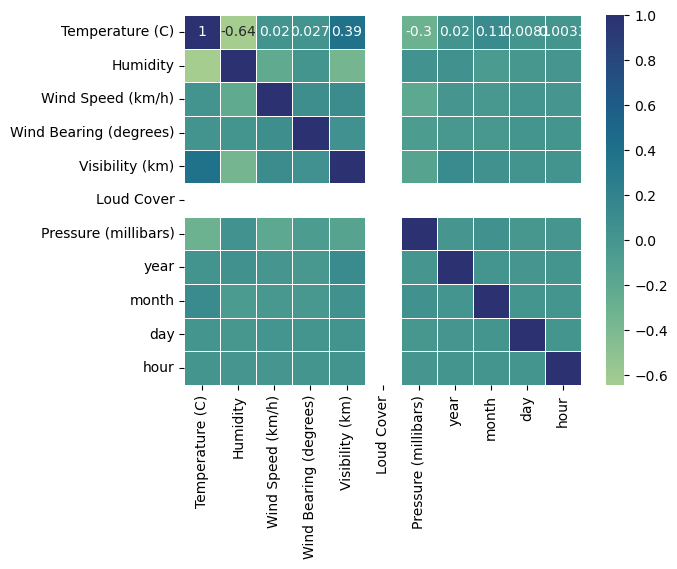

In [13]:
numerical_weather_data = weather_data.select_dtypes(include="number")
correlation_matrix = numerical_weather_data.corr()
sns.heatmap(data=correlation_matrix, annot=True, linewidths=0.7, cmap="crest")
plt.show()

In [14]:
numerical_weather_data = weather_data.select_dtypes(include="number").columns
X = weather_data[numerical_weather_data]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
vif_data

,Feature,VIF
7,year,27855.564804
6,Pressure (millibars),26762.010236
1,Humidity,31.727847
4,Visibility (km),8.984062
0,Temperature (C),5.946732
8,month,4.765589
2,Wind Speed (km/h),4.726684
9,day,4.189694
3,Wind Bearing (degrees),4.076886
10,hour,3.725725


In [15]:
weather_data.drop(labels=["year"], axis=1, inplace=True)
numerical_weather_data = weather_data.select_dtypes(include="number").columns
X = weather_data[numerical_weather_data]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
vif_data

,Feature,VIF
6,Pressure (millibars),67.638744
1,Humidity,27.846173
4,Visibility (km),8.891313
0,Temperature (C),4.881199
7,month,4.739099
2,Wind Speed (km/h),4.336910
8,day,4.186456
3,Wind Bearing (degrees),4.073949
9,hour,3.725342
5,Loud Cover,NaN


In [16]:
weather_data.drop(labels=["Pressure (millibars)"], axis=1, inplace=True)
numerical_weather_data = weather_data.select_dtypes(include="number").columns
X = weather_data[numerical_weather_data]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
vif_data

,Feature,VIF
1,Humidity,8.511458
4,Visibility (km),7.843123
6,month,4.509142
3,Wind Bearing (degrees),4.007957
7,day,3.997376
2,Wind Speed (km/h),3.720149
0,Temperature (C),3.639513
8,hour,3.589095
5,Loud Cover,NaN


In [17]:
weather_data.drop(labels=["Humidity"], axis=1, inplace=True)
numerical_weather_data = weather_data.select_dtypes(include="number").columns
X = weather_data[numerical_weather_data]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
vif_data

,Feature,VIF
3,Visibility (km),7.229500
5,month,3.938804
1,Wind Speed (km/h),3.673196
6,day,3.611892
2,Wind Bearing (degrees),3.597657
7,hour,3.263577
0,Temperature (C),3.184724
4,Loud Cover,NaN


In [18]:
weather_data.drop(labels=["Loud Cover", "Formatted Date"], axis=1, inplace=True)

In [19]:
weather_data.select_dtypes(include="object").columns

Index(['Summary', 'Precip Type', 'Daily Summary'], dtype='object')

In [20]:
one_hot_encoder = OneHotEncoder(sparse_output=True)
encoded_features_summary = pd.get_dummies(weather_data[["Summary"]], prefix="Summary_").astype(int)
encoded_features_precip_type = pd.get_dummies(weather_data[["Precip Type"]], prefix="Precip_Type_").astype(int)
encoded_features_daily_summary = pd.get_dummies(weather_data[["Daily Summary"]], prefix="Daily_Summary_").astype(int)

In [21]:
weather_data.drop(labels=["Summary", "Precip Type"], axis=1, inplace=True)
weather_data.reset_index(drop=True, inplace=True)
encoded_features_summary.reset_index(drop=True, inplace=True)
encoded_features_precip_type.reset_index(drop=True, inplace=True)

In [22]:
weather_data = pd.concat([weather_data, encoded_features_summary, encoded_features_precip_type], axis=1)
weather_data.columns = weather_data.columns.astype(str)

In [23]:
binary_encoder = ce.BinaryEncoder(cols="Daily Summary")
weather_data = binary_encoder.fit_transform(weather_data)

In [24]:
X = weather_data.drop(labels=["Temperature (C)"], axis=1)
y = weather_data["Temperature (C)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [25]:
X_train_1 = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Temperature (C)   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     1631.
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:58:01   Log-Likelihood:            -2.0506e+05
No. Observations:               60356   AIC:                         4.102e+05
Df Residuals:                   60328   BIC:                         4.104e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                4.6479      0.384     12.108      0.000       3.895       5.400
Wind Speed (km/h)                   -0.0074      0.005     -1.416      0.157      -0.018       0.003
Wind Bearing (degrees)              -0.0002      0.000     -0.580      0.562      -0.001       0.000
Visibility (km)                      0.3010      0.010     31.619      0.000       0.282       0.320
Daily Summary_0                     -2.7693      0.221    -12.505      0.000      -3.203      -2.335
Daily Summary_1                     -1.5167      0.138    -10.995      0.000      -1.787      -1.246
Daily Summary_2                      0.3172      0.087      3.638      0.000       0.146       0.488
Daily Summary_3                     -1.2596      0.087    -14.400      0.000      -1.431      -1.088
Daily Summary_4                     -0.3117      0.067     -4.649      0.000      -0.443      -0.180
Daily Summary_5                      0.0592      0.064      0.918      0.358      -0.067       0.186
Daily Summary_6                      0.8639      0.068     12.634      0.000       0.730       0.998
Daily Summary_7                      0.2976      0.066      4.509      0.000       0.168       0.427
month                                0.1064      0.009     12.246      0.000       0.089       0.123
day                                 -0.0032      0.003     -0.946      0.344      -0.010       0.003
hour                                -0.0093      0.004     -2.212      0.027      -0.018      -0.001
Summary__Clear                      -4.3664      0.560     -7.798      0.000      -5.464      -3.269
Summary__Drizzle                    -2.3186      3.901     -0.594      0.552      -9.964       5.327
Summary__Dry                        10.9628      1.631      6.720      0.000       7.765      14.160
Summary__Dry and Mostly Cloudy       8.2886      2.185      3.794      0.000       4.006      12.571
Summary__Dry and Partly Cloudy       7.7444      1.217      6.362      0.000       5.358      10.130
Summary__Foggy                      -6.7626      0.567    -11.918      0.000      -7.875      -5.650
Summary__Humid and Mostly Cloudy     3.1721      1.305      2.432      0.015       0.615       5.729
Summary__Humid and Overcast          2.7463      3.899      0.704      0.481      -4.895      10.388
Summary__Humid and Partly Cloudy     3.8058      2.008      1.896      0.058      -0.129       7.741
Summary__Light Rain                 -5.3357      2.434     -2.192      0.028     -10.107      -0.564
Summary__Mostly Cloudy              -4.3875      0.555     -7.908      0.000      -5.475      -3.300
Summary__Overcast                   -7.6053      0.556    -13.677      0.000      -8.695      -6.515
Summary__Partly Cloudy              -1.2961      0.55

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Forward Selection

In [27]:
forward_selected_features = sfs(lr, k_features="best", forward=True, scoring="r2")
forward_selected_features = forward_selected_features.fit(X_train, y_train)

In [28]:
forward_selected_features.k_score_

0.4214850070702969

In [29]:
len(forward_selected_features.k_feature_names_)

20

#### Backward Elimination

In [30]:
backward_selected_features = sfs(lr, k_features="best", forward=False, scoring="r2")
backward_selected_features.fit(X_train, y_train)
backward_selected_features.k_score_

0.4214850070702969

In [31]:
len(backward_selected_features.k_feature_names_)

20

#### Recursive Feature Elimination

In [32]:
recursively_selected_features = RFE(lr, n_features_to_select=21)
recursively_selected_features = recursively_selected_features.fit(X_train, y_train)

In [33]:
recursively_selected_features.score(X_train, y_train)

0.4108064585805531

### Cross Validation

##### Updating the model to contain only the best features instead of all of them.

In [34]:
X = weather_data[[i for i in forward_selected_features.k_feature_names_]]
y = weather_data["Temperature (C)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_1 = sm.add_constant(X_train)
updated_model = sm.OLS(y_train, X_train_1).fit()
updated_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Temperature (C)   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     2193.
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:59:21   Log-Likelihood:            -2.0520e+05
No. Observations:               60356   AIC:                         4.104e+05
Df Residuals:                   60335   BIC:                         4.106e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -4.4659      0.169    -26.430      0.000      -4.797      -4.135
Wind Speed (km/h)                   -0.0085      0.005     -1.651      0.099      -0.019       0.002
Visibility (km)                      0.2999      0.009     31.677      0.000       0.281       0.318
Daily Summary_0                     -2.6809      0.219    -12.250      0.000      -3.110      -2.252
Daily Summary_1                     -1.5273      0.138    -11.032      0.000      -1.799      -1.256
Daily Summary_2                      0.3781      0.084      4.492      0.000       0.213       0.543
Daily Summary_3                     -1.2231      0.086    -14.171      0.000      -1.392      -1.054
Daily Summary_4                     -0.2904      0.065     -4.491      0.000      -0.417      -0.164
Daily Summary_6                      0.8030      0.068     11.817      0.000       0.670       0.936
Daily Summary_7                      0.2263      0.066      3.449      0.001       0.098       0.355
month                                0.1077      0.009     12.389      0.000       0.091       0.125
Summary__Dry                        13.8338      1.710      8.089      0.000      10.482      17.186
Summary__Dry and Mostly Cloudy      11.6727      2.293      5.090      0.000       7.178      16.168
Summary__Dry and Partly Cloudy      13.0063      1.094     11.884      0.000      10.861      15.152
Summary__Foggy                      -2.3910      0.156    -15.312      0.000      -2.697      -2.085
Summary__Humid and Mostly Cloudy     7.3973      1.481      4.995      0.000       4.495      10.300
Summary__Humid and Overcast          8.6874      4.186      2.075      0.038       0.482      16.893
Summary__Humid and Partly Cloudy     8.2455      2.012      4.099      0.000       4.303      12.188
Summary__Overcast                   -3.2083      0.088    -36.403      0.000      -3.381      -3.036
Summary__Partly Cloudy               3.1007      0.069     45.109      0.000       2.966       3.235
Precip_Type__rain                   13.9081      0.103    134.409      0.000      13.705      14.111
==============================================================================
Omnibus:                      798.611   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              676.951
Skew:                           0.198   Prob(JB):                    1.00e-147
Kurtosis:                       2.666   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
stron

In [35]:
kf = KFold(n_splits=5)

In [36]:
def get_score(model, X_train_k, X_test_k, y_train_k, y_test_k):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test) # Returns the R square value

In [37]:
scores = []
for train_index, test_index in kf.split(X_train):
    X_train_k = X_train.iloc[train_index]
    X_test_k = X_train.iloc[test_index]
    y_train_k = y_train.iloc[train_index]
    y_test_k = y_train.iloc[test_index]

    scores.append(get_score(LinearRegression(), X_train_k, X_test_k, y_train_k, y_test_k))

In [38]:
print("All scores:")
numpy_array_scores = np.array(scores)
print(f"Scores: {scores}")
print(f"Mean of scores: {numpy_array_scores.mean()}")
print(f"Standard Deviation in Scores: {numpy_array_scores.std()}")

All scores:
Scores: [0.41789357417626216, 0.41789357417626216, 0.41789357417626216, 0.41789357417626216, 0.41789357417626216]
Mean of scores: 0.4178935741762622
Standard Deviation in Scores: 5.551115123125783e-17


In [39]:
X_train.columns

Index(['Wind Speed (km/h)', 'Visibility (km)', 'Daily Summary_0',
       'Daily Summary_1', 'Daily Summary_2', 'Daily Summary_3',
       'Daily Summary_4', 'Daily Summary_6', 'Daily Summary_7', 'month',
       'Summary__Dry', 'Summary__Dry and Mostly Cloudy',
       'Summary__Dry and Partly Cloudy', 'Summary__Foggy',
       'Summary__Humid and Mostly Cloudy', 'Summary__Humid and Overcast',
       'Summary__Humid and Partly Cloudy', 'Summary__Overcast',
       'Summary__Partly Cloudy', 'Precip_Type__rain'],
      dtype='object')

In [40]:
tuned_parameters = {'ridge__alpha' : [5, 10, 15, 20]}

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

bayes_search = BayesSearchCV(
    estimator=ridge_pipeline,
    search_spaces=tuned_parameters,
    cv=5,
    n_iter=30,
    scoring='neg_mean_squared_error',
    random_state=0,
    n_jobs=-1
)

bayes_search.fit(X_train, y_train)

print(f"Best parameters are: {bayes_search.best_params_}")
print(f"Best score is: {bayes_search.best_score_}")

Best parameters are: OrderedDict([('ridge__alpha', 20)])
Best score is: -52.581982189688276


In [41]:
y_train_pred = bayes_search.predict(X_train)
y_test_pred = bayes_search.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 7.249005827009776
Test RMSE: 7.229212223861992


In [42]:
y_test_pred

array([14.924633  ,  7.40066446, 17.29956966, ..., -3.30501572,
        0.75406985, -3.44974302])

In [43]:
submission_dataframe = pd.DataFrame({
    'index': X_test.index,
    'Temperature (C)': y_test_pred
})
submission_dataframe.head(2)

,index,Temperature (C)
0,45325,14.924633
1,3017,7.400664


In [44]:
submission_dataframe_file = '../d. Output Files/TemperatureTrends/' + 'TemperatureTrends_Prediction.csv'
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: TemperatureTrends_Prediction.csv
